In [1]:
from __future__ import print_function
import numpy
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt

seed = 123
image_height = 432
image_width = 768
images_path = '../images/'

def process(image):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image

train_ds, test_ds = tensorflow.keras.utils.image_dataset_from_directory(
  images_path,
  label_mode=None,
  color_mode='grayscale',
  validation_split=0.2,
  subset="both",
  seed=seed,
  image_size=(image_height, image_width),
  batch_size=32)

train_ds = train_ds.map(process)
train_ds = train_ds.map(lambda x : (x, x))

test_ds = test_ds.map(process)
test_ds = test_ds.map(lambda x : (x, x))

plt.gray()

Found 4258 files belonging to 1 classes.
Using 3407 files for training.
Using 851 files for validation.


<Figure size 640x480 with 0 Axes>

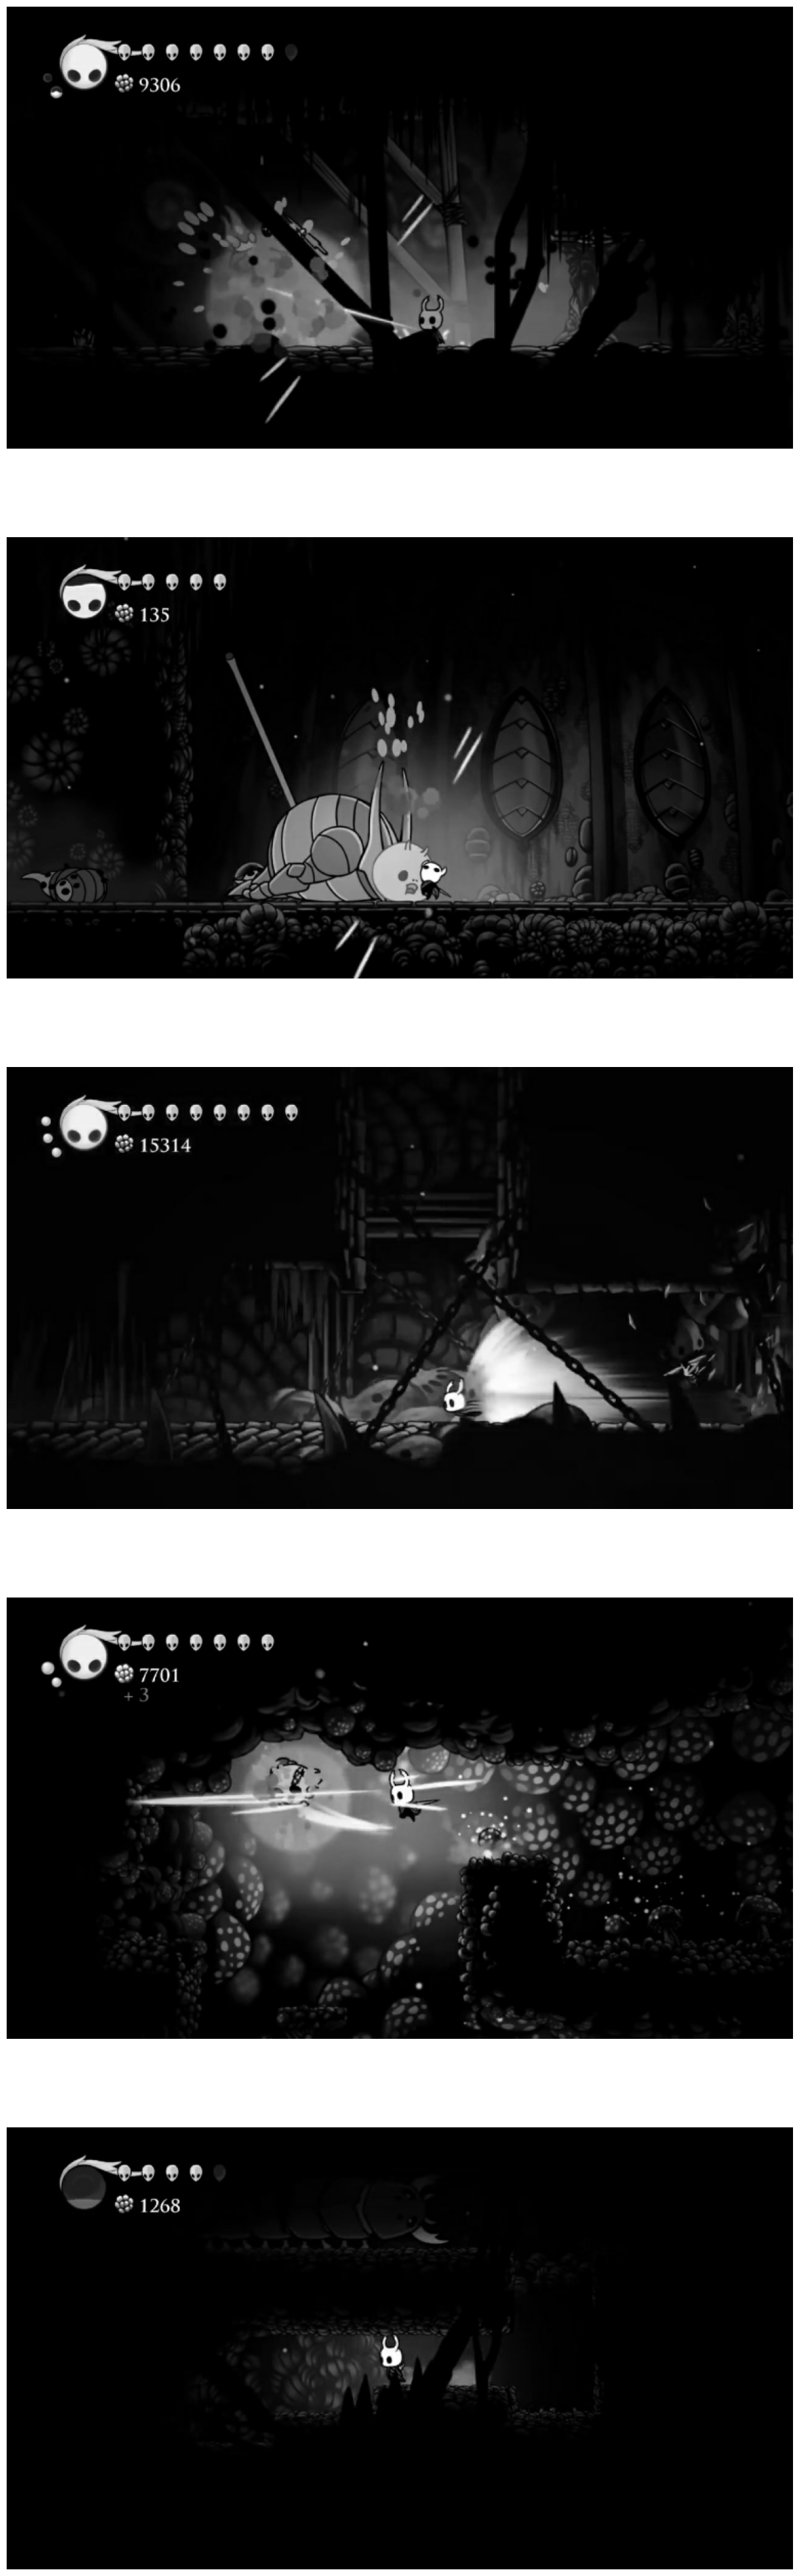

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")


In [3]:
import tensorflow
from keras import mixed_precision
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation
from keras.layers import UpSampling2D
from keras.models import Model

def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

def create_big_compression_model(image_width, image_height):

    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(2, kernel_size=(2, 2), activation='sigmoid', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', dtype='float16')(x)
    print(("shape of encoded", K.int_shape(encoded)))

    # Decoder (upsamling)|
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    # decoded = Activation('sigmoid')(decoded)
    return Model(inputs, decoded)

def create_simple_compression_model(image_width, image_height):

    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(inputs)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', dtype='float16')(x)
    print(("shape of encoded", K.int_shape(encoded)))

    # Decoder (upsamling)|
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    # decoded = Activation('sigmoid')(decoded)
    return Model(inputs, decoded)

def create_4x_compression_model(image_height, image_width):

    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(inputs)
    x = Conv2D(16, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    # x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', dtype='float16')(x)
    print(("shape of encoded", K.int_shape(encoded)))

    # Decoder (upsamling)|
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(encoded)
    # x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    # decoded = Activation('sigmoid')(decoded)
    return Model(inputs, decoded)

mixed_precision.set_global_policy('mixed_float16')
autoencoder = create_big_compression_model(image_height, image_width)
autoencoder.summary()

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss=ssim_loss)
autoencoder.fit(train_ds, epochs=5, validation_data=test_ds, verbose=1)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, compute capability 7.5
('shape of encoded', (None, 108, 192, 4))
('shape of decoded', (None, 432, 768, 1))
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 432, 768, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 432, 768, 2)       10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 384, 2)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 384,

In [8]:
# loss: 0.0676 - val_loss: 0.0727
# after 160 epochs - loss 0.0392

# 4x
# loss: 60 epochs - 0.1301
# loss: > 1000 epochs - 0.0784
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss=losses.MeanSquaredError())
autoencoder.fit(train_ds, epochs=5, validation_data=test_ds, verbose=1)

Epoch 1/5
107/107 [==============================] - 93s 869ms/step - loss: 0.0367 - val_loss: 0.0363
Epoch 2/5
107/107 [==============================] - 93s 870ms/step - loss: 0.0357 - val_loss: 0.0354
Epoch 3/5
107/107 [==============================] - 93s 869ms/step - loss: 0.0349 - val_loss: 0.0345
Epoch 4/5
107/107 [==============================] - 93s 871ms/step - loss: 0.0342 - val_loss: 0.0339
Epoch 5/5
107/107 [==============================] - 93s 871ms/step - loss: 0.0338 - val_loss: 0.0334


1/1 [==============================] - 0s 26ms/step


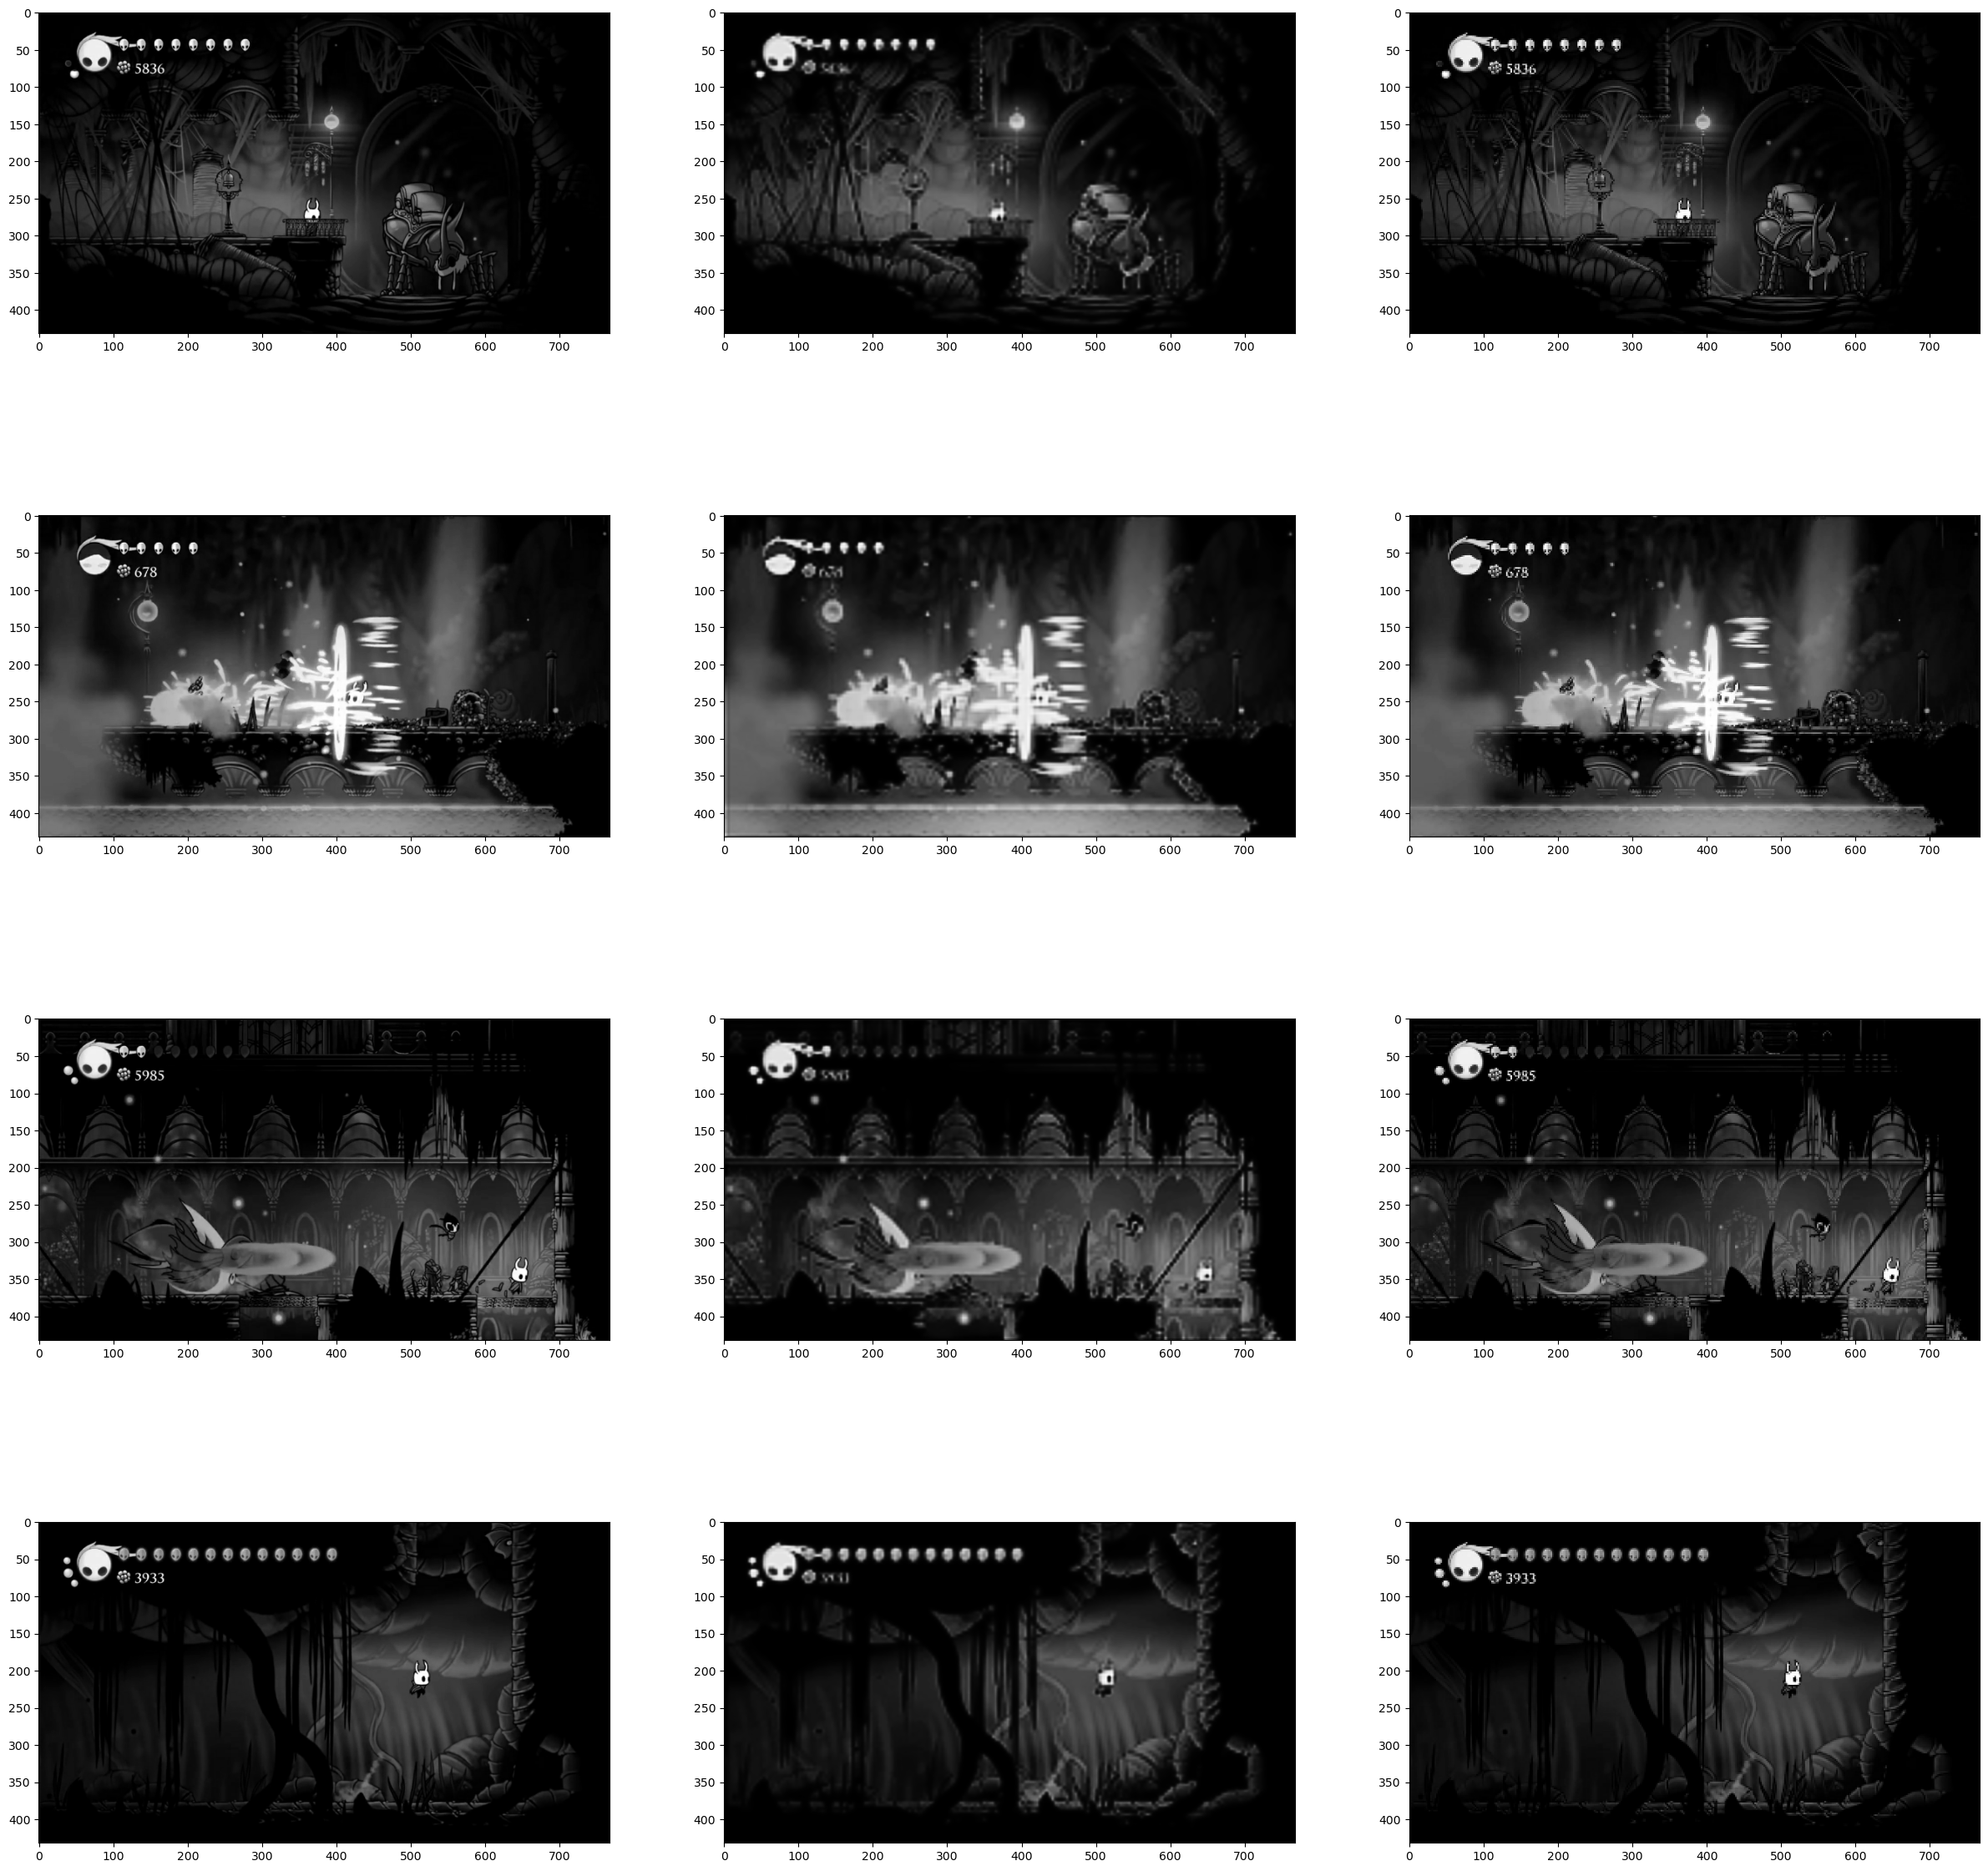

In [9]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = [x for x, y in test_ds.take(1)]
test_images = test_images[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    manual_compression = in_img[::2,::2]
    manual_compression = manual_compression.numpy().repeat(2, axis=0).repeat(2, axis=1)
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(manual_compression)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')